In [1]:
import pandas as pd

my_books = pd.read_csv("liked_books.csv", index_col=0)

In [2]:
my_books

,user_id,book_id,rating,title
0,-1,2517439,5,"The Forever War (The Forever War, #1)"
1,-1,113576,5,The Smartest Guys in the Room: The Amazing Ris...
2,-1,35100,5,Battle Cry of Freedom
3,-1,228221,5,The Mask of Command
5,-1,17662739,5,"2001: A Space Odyssey (Space Odyssey, #1)"
6,-1,356824,5,India After Gandhi: The History of the World's...
7,-1,12125412,5,The Lady or the Tiger?: and Other Logic Puzzles
8,-1,139069,5,Endurance: Shackleton's Incredible Voyage
10,-1,76680,5,"Foundation (Foundation, #1)"
11,-1,1898,5,Into Thin Air: A Personal Account of the Mount...


In [14]:
my_books["book_id"] = my_books["book_id"].astype(str)

In [15]:
#creates a dictionary that'll help us map between the two ID's

csv_book_mapping = {}

with open("book_id_map.csv", "r") as f:
    while True:
        line = f.readline()
        if not line:
            break 
        csv_id, book_id = line.strip().split(",")
        csv_book_mapping[csv_id] = book_id

In [16]:
#create a set that contains all the unique books we've read
#ensures we can look for users who've read the same book as us
book_set = set(my_books["book_id"])

In [17]:
#save all the users that have read the same books as us in a set

overlap_users = {}

with open("goodreads_interactions.csv") as f:
    while True:
        line = f.readline()
        if not line:
            break
    
        user_id, csv_id, _, rating, _ = line.strip().split(",")

        book_id = csv_book_mapping.get(csv_id)
        #if this is one of the books we've read, then add user to the set
        if book_id in book_set:
            if user_id not in overlap_users:
                overlap_users[user_id] = 1
            else:
                overlap_users[user_id] += 1

In [18]:
len(overlap_users)

316341

In [19]:
#filtering reduces the number of users we have to compare our own books against to get recommendations
filtered_overlap_users = set([k for k in overlap_users if overlap_users[k] > my_books.shape[0]/5])

In [21]:
interactions_list = []

with open("goodreads_interactions.csv") as f:
    while True:
        line = f.readline()
        if not line:
            break
    
        user_id, csv_id, _, rating, _ = line.strip().split(",")
        if user_id in filtered_overlap_users:
            book_id = csv_book_mapping[csv_id]
            interactions_list.append([user_id, book_id, rating])

# Creating a user/book matrix

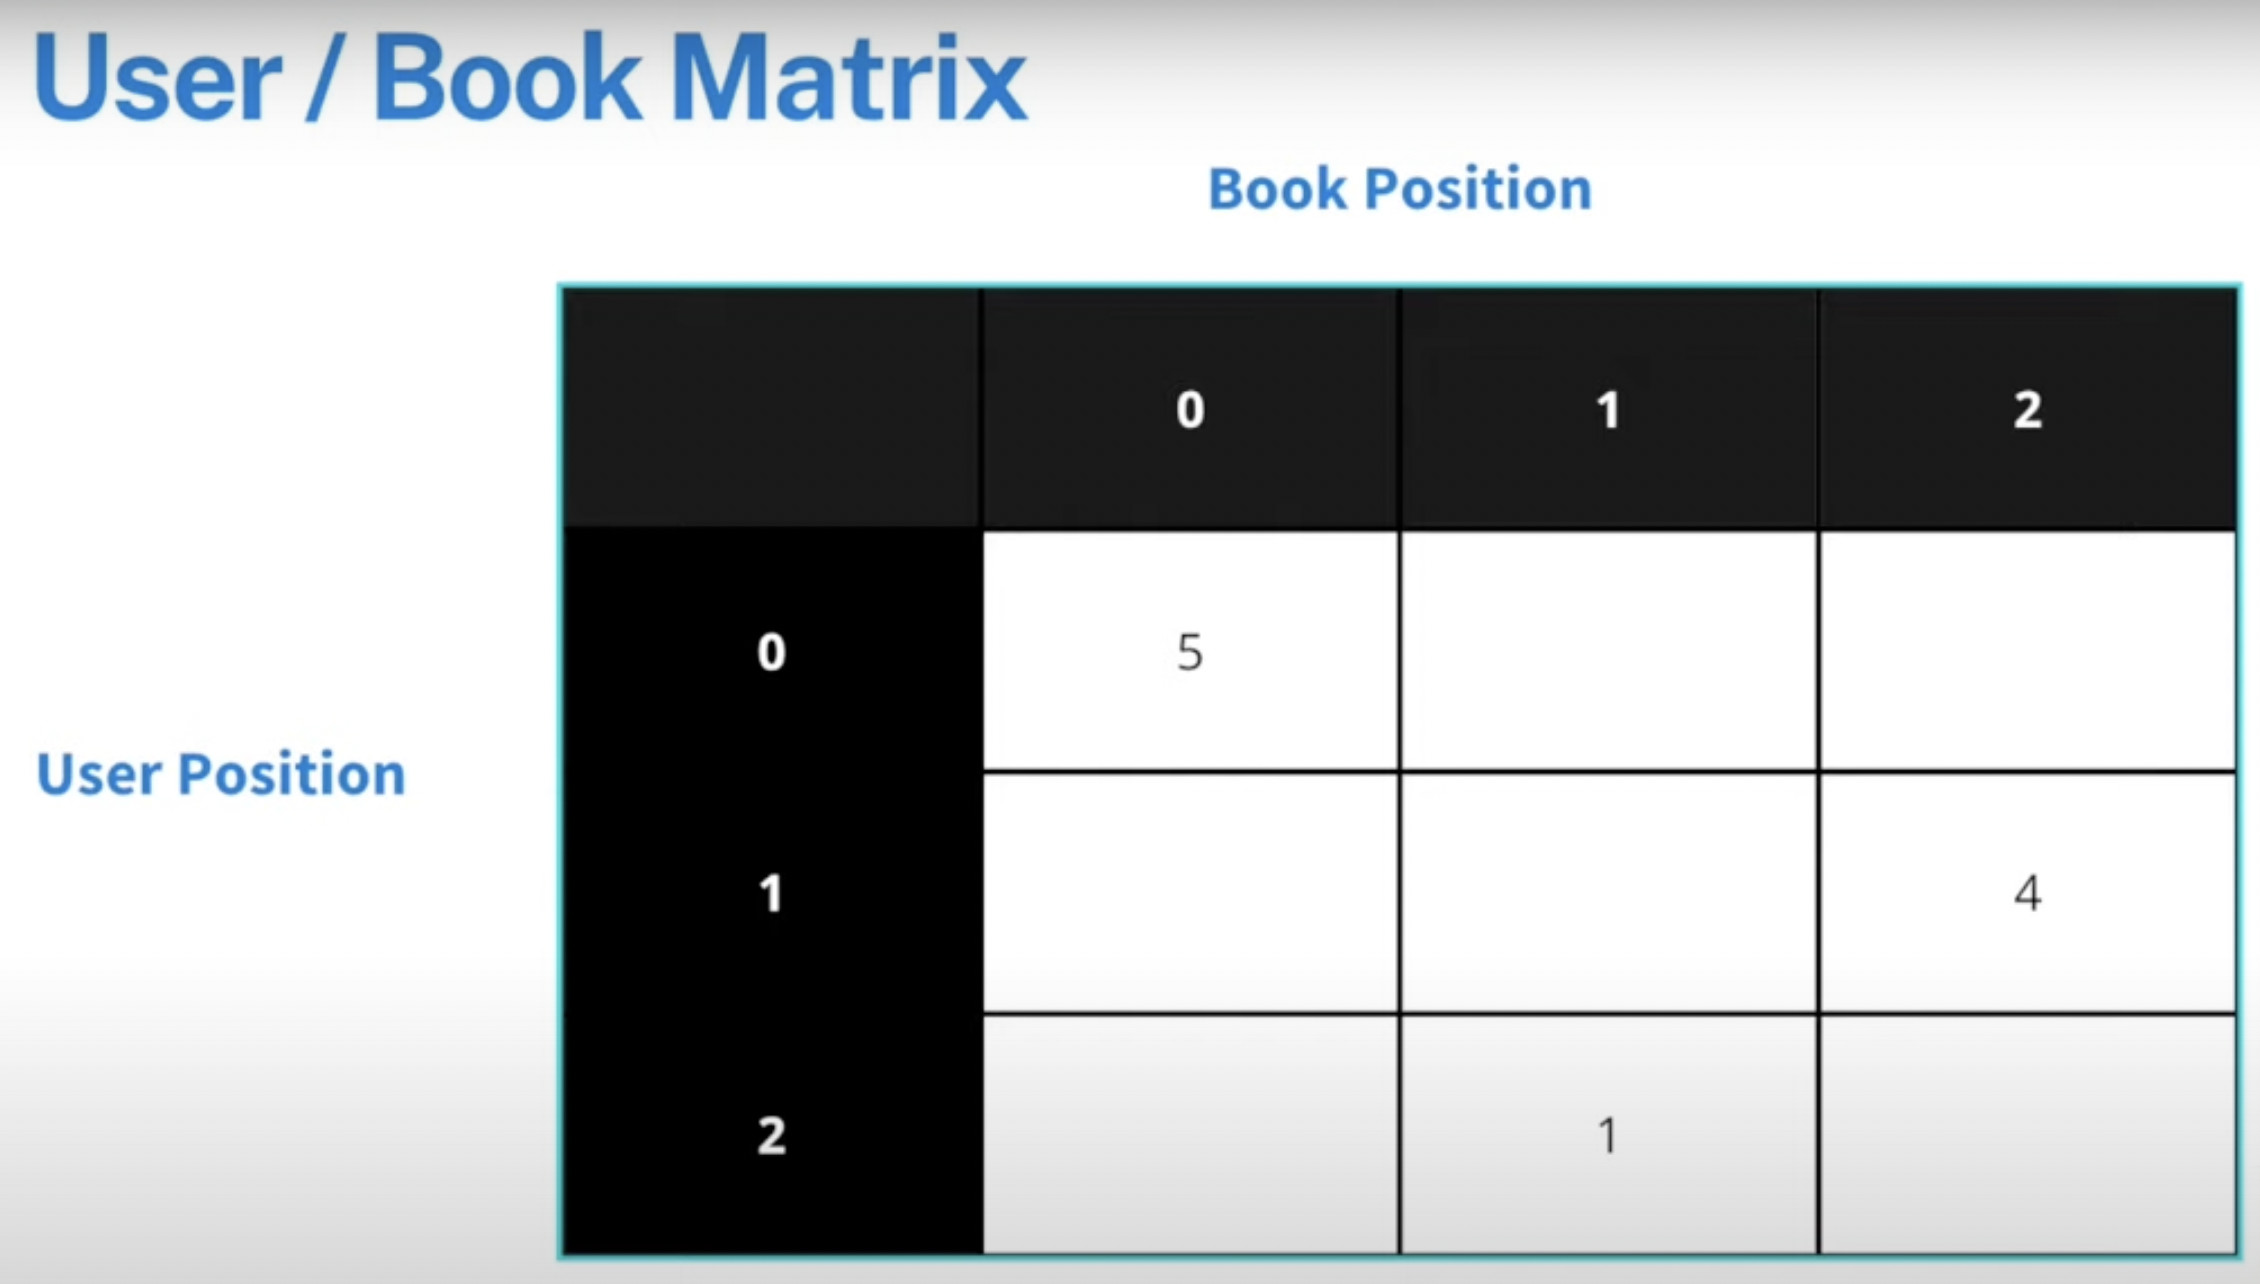

Every row of the matrix is a different user and every column of the matrix is a different book. The cells will contain the rating that user gave that book.

In [22]:
len(interactions_list)

5638701

In [23]:
interactions_list[0]

['282', '627206', '4']

In [24]:
interactions = pd.DataFrame(interactions_list, columns = ['user_id', 'book_id',"rating"])

In [25]:
#add my books to the matrix
interactions = pd.concat([my_books[["user_id", "book_id","rating"]], interactions])

In [26]:
interactions

,user_id,book_id,rating
0,-1,2517439,5
1,-1,113576,5
2,-1,35100,5
3,-1,228221,5
5,-1,17662739,5
...,...,...,...
5638696,804100,475178,0
5638697,804100,186074,0
5638698,804100,153008,0
5638699,804100,45107,0


In [27]:
interactions["book_id"] = interactions["book_id"].astype(str)
interactions["user_id"] = interactions["user_id"].astype(str)
interactions["rating"] = pd.to_numeric(interactions["rating"])

In [28]:
interactions["user_id"].unique()

array(['-1', '282', '874', ..., '442043', '712588', '804100'],
      dtype=object)

In [30]:
#the above id's are too long so we'll create an index and renumber them as 0,1,2...
#category - all the same numbers will be converted into the same category
#in our case each id will be its own category and that category is assigned a code 0,1,2,...
interactions["user_index"] = interactions["user_id"].astype("category").cat.codes

In [33]:
interactions["user_index"].unique()

array([   0,  555, 1216, ..., 1054, 1143, 1183], dtype=int16)

In [34]:
interactions["book_index"] = interactions["book_id"].astype("category").cat.codes

In [35]:
len(interactions['book_index'].unique())

802870

In [36]:
len(interactions['user_index'].unique())

1259

In [38]:
802870*1259 #this is a shit tone of unique matrix cells

1010813330

We'll create a sparse matrix rather than a dense matrix which is what's generally used in numpy, pandas. sparse matrix is a little bit more complicated to create, but it will save us memory

In [39]:
from scipy.sparse import coo_matrix #coo matrix is a type of sparse matrix

ratings_mat_coo = coo_matrix((interactions["rating"],(interactions["user_index"], interactions["book_index"])))

In [40]:
ratings_mat_coo

<1259x802870 sparse matrix of type '<class 'numpy.int64'>'
	with 5638728 stored elements in COOrdinate format>

In [42]:
ratings_mat = ratings_mat_coo.tocsr() #convert to csr matrix

# Finding users similar to us

In [43]:
interactions[interactions["user_id"] =="-1"]

,user_id,book_id,rating,user_index,book_index
0,-1,2517439,5,0,414880
1,-1,113576,5,0,38971
2,-1,35100,5,0,575858
3,-1,228221,5,0,356004
5,-1,17662739,5,0,214285
6,-1,356824,5,0,581743
7,-1,12125412,5,0,59763
8,-1,139069,5,0,124430
10,-1,76680,5,0,722098
11,-1,1898,5,0,276178


In [44]:
#use cosine similarity measure to find similar users

In [45]:
my_index = 0

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()

In [50]:
#similarity of 1 means exactly the same taste
similarity[4]

0.0025870109564043505

In [51]:
#find users with high similarity in taste
#top 15 users with the most similarity
import numpy as np

indices = np.argpartition(similarity, -15)[-15:]

In [53]:
indices

array([1188,  942,  218,  129,  496,  435, 1208,  795, 1213, 1210, 1143,
        321,  294,  862,    0])

In [55]:
similar_users = interactions[interactions["user_index"].isin(indices)].copy()

In [56]:
similar_users = similar_users[similar_users["user_id"] != "-1"]

In [57]:
similar_users

,user_id,book_id,rating,user_index,book_index
45312,4133,5359,3,942,632143
45313,4133,10464963,4,942,13492
45314,4133,3858,3,942,593622
45315,4133,11827808,4,942,51904
45316,4133,7913305,4,942,732465
...,...,...,...,...,...
5638521,712588,32388712,3,1143,543119
5638522,712588,16322,5,1143,183365
5638523,712588,860543,0,1143,759827
5638524,712588,853510,5,1143,756768


# Creating Book Recommendations

In [58]:
book_recs = similar_users.groupby("book_id").rating.agg(['count','mean'])

In [59]:
#count tells how many times a book was recommended
#mean tells us the average score the users rated it
book_recs 

,count,mean
book_id,,
1,6,3.833333
100322,1,0.000000
100365,1,0.000000
10046142,1,0.000000
1005,3,0.000000
...,...,...
99561,2,2.500000
99610,1,3.000000
99664,1,4.000000


In [62]:
books_titles = pd.read_json("books_titles.json")
books_titles["book_id"] = books_titles["book_id"].astype(str)

In [63]:
book_recs = book_recs.merge(books_titles, how="inner", on = "book_id")

In [64]:
book_recs

,book_id,count,mean,title,ratings,url,cover_image,mod_title
0,1,6,3.833333,Harry Potter and the Half-Blood Prince (Harry ...,1713866,https://www.goodreads.com/book/show/1.Harry_Po...,https://images.gr-assets.com/books/1361039191m...,harry potter and the halfblood prince harry po...
1,100322,1,0.000000,Assata: An Autobiography,11057,https://www.goodreads.com/book/show/100322.Assata,https://images.gr-assets.com/books/1328857268m...,assata an autobiography
2,100365,1,0.000000,The Mote in God's Eye,48736,https://www.goodreads.com/book/show/100365.The...,https://images.gr-assets.com/books/1399490037m...,the mote in gods eye
3,10046142,1,0.000000,Dancing in the Glory of Monsters: The Collapse...,2391,https://www.goodreads.com/book/show/10046142-d...,https://images.gr-assets.com/books/1328757755m...,dancing in the glory of monsters the collapse ...
4,1005,3,0.000000,Think and Grow Rich,87634,https://www.goodreads.com/book/show/1005.Think...,https://s.gr-assets.com/assets/nophoto/book/11...,think and grow rich
...,...,...,...,...,...,...,...,...
2843,99561,2,2.500000,Looking for Alaska,804587,https://www.goodreads.com/book/show/99561.Look...,https://images.gr-assets.com/books/1394798630m...,looking for alaska
2844,99610,1,3.000000,The Best Laid Plans,17434,https://www.goodreads.com/book/show/99610.The_...,https://images.gr-assets.com/books/1353374848m...,the best laid plans
2845,99664,1,4.000000,The Painted Veil,24606,https://www.goodreads.com/book/show/99664.The_...,https://images.gr-assets.com/books/1320421719m...,the painted veil
2846,9969571,3,2.333333,Ready Player One,376328,https://www.goodreads.com/book/show/9969571-re...,https://images.gr-assets.com/books/1500930947m...,ready player one


# Ranking our book recs

In [65]:
#we're finding the books that are popular amongst similar users but *not* popular amongst users not similar to us
#gets rid of more popular books
book_recs["adjusted_count"] = book_recs["count"]*(book_recs["count"]/book_recs["ratings"])

In [66]:
book_recs["score"] = book_recs["mean"] * book_recs["adjusted_count"]

In [67]:
#remove books we've based on the book id and...
book_recs = book_recs[~book_recs["book_id"].isin(my_books["book_id"])]

In [68]:
#...based on the title
#two ways because the data isn't the cleanest and there are duplicates
my_books["mod_title"] = my_books["title"].str.replace("[^a-zA-Z0-9]","", regex=True).str.lower()

In [69]:
#replace sequences of spaces
my_books["mod_title"] = my_books["mod_title"].str.replace("\s+"," ",regex=True)

In [70]:
#remove any of the books we read from the recs
book_recs = book_recs[~book_recs["mod_title"].isin(my_books["mod_title"])]

In [72]:
#remove any books that appeared less than 3 times
book_recs = book_recs[book_recs["count"]>2]

In [73]:
book_recs = book_recs[book_recs["mean"]>4]

In [74]:
top_recs = book_recs.sort_values("score", ascending = False)

In [76]:
def make_clickable(val):
    return '<a target="_blank" href="{}">Goodreads</a>'.format(val)

def show_image(val):
    return '<img src = "{}" width=50></img>'.format(val)

In [77]:
top_recs.style.format({'url': make_clickable, 'cover_image':show_image})

,book_id,count,mean,title,ratings,url,cover_image,mod_title,adjusted_count,score
2558,78983,4,4.250000,"Kane and Abel (Kane and Abel, #1)",75215,Goodreads,,kane and abel kane and abel 1,0.000213,0.000904
1441,2767793,4,4.250000,"The Hero of Ages (Mistborn, #3)",149260,Goodreads,,the hero of ages mistborn 3,0.000107,0.000456
2260,62291,5,4.800000,"A Storm of Swords (A Song of Ice and Fire, #3)",477834,Goodreads,,a storm of swords a song of ice and fire 3,0.000052,0.000251
1173,2318271,3,4.333333,The Last Lecture,245804,Goodreads,,the last lecture,0.000037,0.000159
1100,22034,3,4.333333,The Godfather,259150,Goodreads,,the godfather,0.000035,0.000150
243,119322,4,4.250000,"The Golden Compass (His Dark Materials, #1)",973154,Goodreads,,the golden compass his dark materials 1,0.000016,0.000070
1906,4381,3,4.333333,Fahrenheit 451,591506,Goodreads,,fahrenheit 451,0.000015,0.000066
600,157993,3,4.333333,The Little Prince,763309,Goodreads,,the little prince,0.000012,0.000051


# Next Steps

1. Filtered Users - Try filtering less or more 
2. Scrape goodreads to get all of your liked books
3. Find more similar users (we only took top 15)
4. You can try to weight the recommendation based on how similar the user is to you. More similar, higher weight, more you value their rec